# Demand Forecast: LSTM Model

In [3]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from scipy.stats import skewnorm
from sklearn.model_selection import train_test_split
import re
import json
import pickle
import os

/var/folders/x4/_l78dvs92m346fbfkb6pl1h40000gn/T/ipykernel_75741/1581927760.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


### scrapping weather data

In [25]:
def read_weather_data():
    try:
        # Open the JSON file
        with open('next_7_day.json', 'r') as file:
            # Load data from the JSON file
            weather_data = json.load(file)
        
        # Print the weather data
        for entry in weather_data:
            print(entry)
    except FileNotFoundError:
        print("File not found. Please check the filename and try again.")
    except json.JSONDecodeError:
        print("Error decoding JSON. Please check the JSON file for errors.")

# Run the function
# read_weather_data()


### weather data processing

In [26]:
def weather_data_processing():
    data = json.load(open('next_7_day.json'))
    df = pd.DataFrame(data)
    df = df.iloc[0:7]
    df['heavy_rainfall_flg'] = np.where(df['weatherCondition'].str.contains('shower|storm',case=False), 1, 0)
    df.drop(columns=['feelsLike','weatherIcon','wind','humidity','precipitationChance','precipitationAmount','description'], inplace=True)

    def clean_text(text):
        """Remove HTML tags and unwanted spaces from text."""
        text = re.sub('<[^<]+?>', '', text) 
        text = text.replace('&nbsp;', ' ')   
        text = re.sub('\s+', ' ', text)  
        return text.strip()
    
    df['temperature'] = df['temperature'].apply(clean_text)
    df['day'] = df['day'].apply(clean_text)
    
    
    today = datetime.now().date()
    df['date'] = [today + timedelta(days=i) for i in range(7)]
    df['date'] = pd.to_datetime(df['date'])

    df.drop(columns=['day'], inplace=True)

    df['max_temp'] = df['temperature'].str.slice(0,2)
    df['min_temp'] = df['temperature'].str.slice(4,7)
    df.drop(columns=['temperature'], inplace=True)


    df['max_temp'] = df['max_temp'].astype(int)
    df['min_temp'] = df['min_temp'].astype(int)
    df['Temperature'] = (df['max_temp'] + df['min_temp']) / 2

    df.drop(columns=['max_temp','min_temp'], inplace=True)
    return df

weather_df = weather_data_processing()

### prepare sg public holiday dataset in 2024

In [27]:
def generate_holiday_df(year):
    import datetime 
    start_date = datetime.date(year, 1, 1)
    end_date = datetime.date(year, 12, 31)

    # List of holidays in Singapore for the given year
    holidays_sg = [
        datetime.date(year, 1, 1), datetime.date(year, 2, 10), datetime.date(year, 2, 11),
        datetime.date(year, 3, 29), datetime.date(year, 4, 10), datetime.date(year, 5, 1),
        datetime.date(year, 5, 20), datetime.date(year, 6, 17), datetime.date(year, 8, 9),
        datetime.date(year, 10, 31), datetime.date(year, 12, 25)
    ]

    day_to_number = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    holiday_sg_24 = []
    current_date = start_date
    while current_date <= end_date:
        day_of_week = current_date.strftime('%A')
        holiday_flg_sg = 1 if current_date in holidays_sg else 0
        holiday_sg_24.append([current_date.strftime('%Y-%m-%d'), day_of_week, holiday_flg_sg])
        current_date += datetime.timedelta(days=1)

    holiday_sg_24 = pd.DataFrame(holiday_sg_24, columns=['calendar_date', 'day_of_week', 'holiday_flg_sg'])
    holiday_sg_24['day_of_week'] = holiday_sg_24['day_of_week'].map(day_to_number)

    return holiday_sg_24

holiday_sg_24 = generate_holiday_df(2024)

### LSTM Model Training

#### 1. Data Preparation and Feature Engineering

In [28]:
def feature_engineering():
    visitor_data = pd.read_csv("synthetic_visit_data.csv")
    visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])
    weather_data = pd.read_csv("weather_data_cleaned.csv")
    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    columns_to_drop = weather_data.columns[0:3].tolist()
    weather_data.drop(columns=columns_to_drop, inplace=True)
    holiday_data = pd.read_csv("date_info_2324.csv")
    holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
    holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
    holiday_data.drop(columns="day_of_week", inplace=True)

    merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
    merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
    merged_data.drop(columns=["Date","calender_date","Highest 30 min Rainfall (mm)","Highest 60 min Rainfall (mm)","Highest 120 min Rainfall (mm)","Maximum Temperature (°C)","Minimum Temperature (°C)","Mean Wind Speed (km/h)","Max Wind Speed (km/h)"], inplace=True)
    merged_data.head()

    day_mapping = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    merged_data['month'] = pd.to_datetime(merged_data['visit_date']).dt.month
    merged_data['day'] = pd.to_datetime(merged_data['visit_date']).dt.day
    merged_data['week_of_year'] = pd.to_datetime(merged_data['visit_date']).dt.isocalendar().week
    merged_data['day_of_week'] = merged_data['day_of_week'].replace(day_mapping)

    merged_data['heavy_rainfall_flg'] = (merged_data['Daily Rainfall Total (mm)'] > 20).astype(int)

    merged_data['temperature_category'] = pd.cut(merged_data['Mean Temperature (°C)'],
                                                bins=[-np.inf, 15, 25, np.inf],
                                                labels=['cold', 'mild', 'hot'])

    merged_data['is_holiday'] = merged_data[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)

    merged_data = pd.get_dummies(merged_data, 'temperature_category')

    merged_data.drop(columns=["Daily Rainfall Total (mm)", "Mean Temperature (°C)", 
                            "holiday_flg_sg", "holiday_flg_cn", "holiday_flg_in", 'visit_date'], inplace=True)

    for lag in range(1, 8):  # 7 days lag
        merged_data[f'visitors_lag_{lag}'] = merged_data['visitors'].shift(lag)

    merged_data['rolling_mean_visitors'] = merged_data['visitors'].rolling(window=7).mean().shift(1)
    merged_data['rolling_std_visitors'] = merged_data['visitors'].rolling(window=7).std().shift(1)

    merged_data.fillna(method='bfill', inplace=True)
    return merged_data

feature_engineering()

,day_of_week,visitors,month,day,week_of_year,heavy_rainfall_flg,is_holiday,temperature_category_cold,temperature_category_mild,temperature_category_hot,visitors_lag_1,visitors_lag_2,visitors_lag_3,visitors_lag_4,visitors_lag_5,visitors_lag_6,visitors_lag_7,rolling_mean_visitors,rolling_std_visitors
0,7,409,1,1,52,0,1,0,0,1,409.0,409.0,409.0,409.0,409.0,409.0,409.0,222.142857,120.380547
1,1,276,1,2,1,0,1,0,0,1,409.0,409.0,409.0,409.0,409.0,409.0,409.0,222.142857,120.380547
2,2,158,1,3,1,0,0,0,0,1,276.0,409.0,409.0,409.0,409.0,409.0,409.0,222.142857,120.380547
3,3,118,1,4,1,0,0,0,0,1,158.0,276.0,409.0,409.0,409.0,409.0,409.0,222.142857,120.380547
4,4,110,1,5,1,1,0,0,0,1,118.0,158.0,276.0,409.0,409.0,409.0,409.0,222.142857,120.380547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,7,473,2,25,8,0,0,0,0,1,454.0,233.0,130.0,116.0,122.0,107.0,452.0,230.571429,157.721122
421,1,109,2,26,9,0,0,0,0,1,473.0,454.0,233.0,130.0,116.0,122.0,107.0,233.571429,162.754270
422,2,126,2,27,9,0,0,0,0,1,109.0,473.0,454.0,233.0,130.0,116.0,122.0,233.857143,162.496593
423,3,100,2,28,9,0,0,0,0,1,126.0,109.0,473.0,454.0,233.0,130.0,116.0,234.428571,162.044086


In [29]:
# Preparing data for LSTM
df = feature_engineering()
X = df.drop(['visitors'], axis=1)
y = df['visitors']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

#### 4. Building Model and Hyperparameter Tunning using Hyperband

In [19]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=20, max_value=100, step=20), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and execute the hyperparameter tuner
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])
best_model = tuner.get_best_models(num_models=1)[0]

Trial 90 Complete [00h 00m 26s]
val_loss: 0.018310582265257835

Best val_loss So Far: 0.017603885382413864
Total elapsed time: 00h 14m 09s


#### 5. Saving the Best Model

To export a Keras model using Python's pickle module, despite the potential risks and incompatibilities mentioned earlier, we can proceed by pickling the model weights and architecture separately. This method allows a form of manual reconstruction which can somewhat mitigate the issues of directly pickling the entire model object.

In [30]:
import pickle

model_json = best_model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

best_model.save_weights('model_weights.weights.h5')

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_y, scaler_file)

NameError: name 'best_model' is not defined

#### 6. Loading the Saved Best Model

In [31]:
#TO LOAD PICKLE FILE:
from tensorflow.keras.models import model_from_json

# Load the architecture
with open('model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# Load the weights
model.load_weights('model_weights.weights.h5')

# Load the scaler
with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


#### 7. Evaluation of Model

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0234 
Test Loss: 0.02199520729482174
RMSE: 66.958


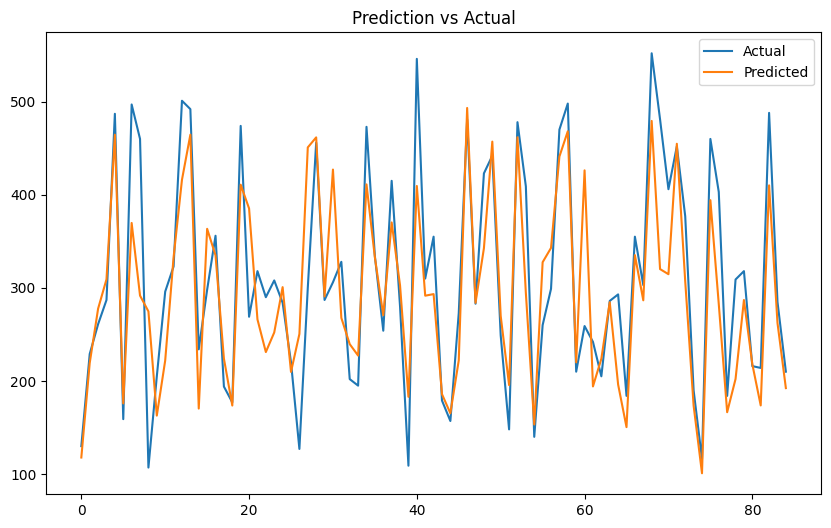

In [32]:
# Predict
predictions = model.predict(X_test)
#inverse transform predictions and y_test for comparison
predictions_inv = scaler_y.inverse_transform(predictions)
y_test_inv = scaler_y.inverse_transform(y_test)
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f"RMSE: {rmse:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.title('Prediction vs Actual')
plt.show()

### Preparing Prediction Dataframe

In [33]:
def prediction_data():
    weather_df = weather_data_processing()
    holiday_sg_24 = generate_holiday_df(2024)

    weather_df['date'] = pd.to_datetime(weather_df['date'])
    holiday_sg_24['calendar_date'] = pd.to_datetime(holiday_sg_24['calendar_date'])
    prediction_df = pd.merge(weather_df, holiday_sg_24, left_on='date', right_on='calendar_date', how='left')
    prediction_df.drop(columns=['weatherCondition', 'calendar_date'], inplace=True)
    prediction_df['day_of_week'] = prediction_df['date'].dt.day_name()
    prediction_df['week_of_year'] = pd.to_datetime(prediction_df['date']).dt.isocalendar().week
    prediction_df['temperature_category'] = pd.cut(prediction_df['Temperature'], bins=[-np.inf, 15, 25, np.inf], labels=['cold', 'mild', 'hot'])
    prediction_df.drop(columns='Temperature', inplace=True)
    prediction_df = pd.get_dummies(prediction_df, columns=['temperature_category'])
    prediction_df.rename(columns={'holiday_flg_sg': 'is_holiday'}, inplace=True)

    day_mapping = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    prediction_df['month'] = pd.to_datetime(prediction_df['date']).dt.month
    prediction_df['day'] = pd.to_datetime(prediction_df['date']).dt.day
    prediction_df['week_of_year'] = pd.to_datetime(prediction_df['date']).dt.isocalendar().week
    prediction_df['day_of_week'] = prediction_df['day_of_week'].replace(day_mapping)
    prediction_df.set_index('date', inplace=True)
    feature_df = feature_engineering()
    prediction_df = pd.merge(prediction_df, feature_df[['visitors_lag_1','visitors_lag_2','visitors_lag_3','visitors_lag_4','visitors_lag_5','visitors_lag_6', 'visitors_lag_7', 'rolling_mean_visitors', 'rolling_std_visitors', 'month', 'day']], on=['month', 'day'], how='left')

    return prediction_df

X_predict = prediction_data()

### Generating Daily Prediction For the Next 7 Days

In [35]:
def generate_daily_prediction():
    X_predict_scaled = loaded_scaler.fit_transform(X_predict)
    X_predict_scaled = X_predict_scaled.reshape(X_predict_scaled.shape[0], 1, X_predict_scaled.shape[1])
    prediction_7days = model.predict(X_predict_scaled)
    prediction_7days_inv = scaler_y.inverse_transform(prediction_7days)
    prediction_7days_inv
    daily_prediction_df = pd.DataFrame(prediction_7days_inv, columns=['Predicted Values'])
    daily_prediction_df

    future_dates = pd.date_range(start=datetime.today(), periods=7, freq='D')
    future_predictions = pd.DataFrame({
        'date': future_dates,
        'predicted_visitors': np.round(daily_prediction_df['Predicted Values']).clip(upper=300) # maximum capacity of restairant = 300
    })
    daily_predictions_7days = future_predictions
    daily_predictions_7days['date'] = pd.to_datetime(daily_predictions_7days['date']).dt.date
    return daily_predictions_7days

generate_daily_prediction()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


,date,predicted_visitors
0,2024-04-24,201.0
1,2024-04-25,95.0
2,2024-04-26,66.0
3,2024-04-27,132.0
4,2024-04-28,239.0
5,2024-04-29,300.0
6,2024-04-30,300.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


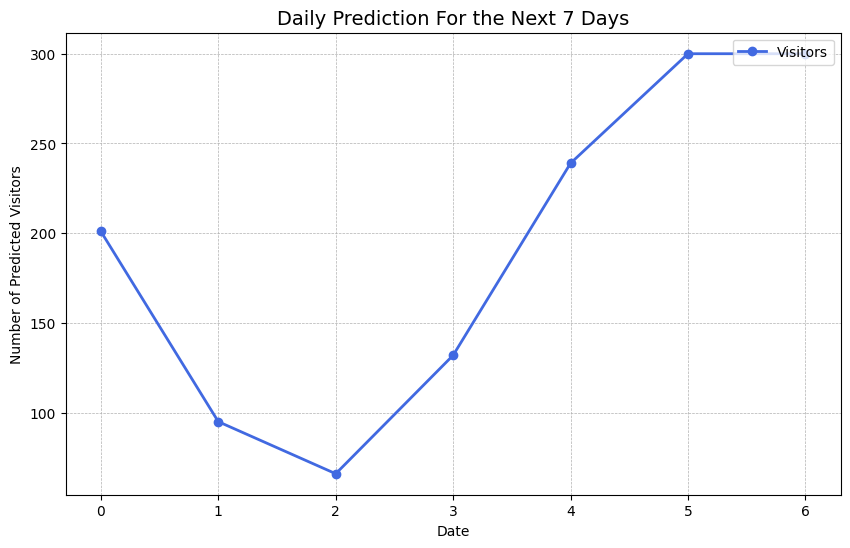

In [39]:
df = generate_daily_prediction()

plt.figure(figsize=(10, 6))
plt.plot(df['predicted_visitors'], linestyle='-', color='royalblue', linewidth=2, marker='o', label='Visitors')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.title('Daily Prediction For the Next 7 Days', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Number of Predicted Visitors')
plt.show()

### Generating Hourly Prediction For the Next 7 Days

In [51]:
def simulate_hourly_arrival(predicted_daily_visitors):
    time_intervals_1 = np.linspace(8, 16, 9)  # From 8 AM to 4 PM (9 hours)
    time_intervals_2 = np.linspace(17, 23, 7)  # From 5 PM to 11 PM (7 hours)
    time_intervals_strings = [f'{int(hour)}:00' for hour in np.concatenate((time_intervals_1, time_intervals_2), axis=None)]
    
    visitor_counts_1 = skewnorm.pdf(time_intervals_1, a=2, loc=12)  # Skew towards noon
    visitor_counts_2 = skewnorm.pdf(time_intervals_2, a=5, loc=19)  # Skew towards evening
    visitor_counts_1 = visitor_counts_1 / visitor_counts_1.max()  # Normalize to [0, 1]
    visitor_counts_2 = visitor_counts_2 / visitor_counts_2.max()
    
    visitor_counts_1 = np.round(visitor_counts_1 * predicted_daily_visitors * 0.4 / visitor_counts_1.sum()).astype(int)
    visitor_counts_2 = np.round(visitor_counts_2 * predicted_daily_visitors * 0.6 / visitor_counts_2.sum()).astype(int)
    
    hourly_counts = np.concatenate((visitor_counts_1, visitor_counts_2), axis=None)
    return time_intervals_strings, hourly_counts

def generate_hourly_data(prediction_7days):
    output_df = pd.DataFrame(columns=['date', 'time', 'estimated_arrival_count'])

    for idx, row in prediction_7days.iterrows():
        time_strings, hourly_visitors = simulate_hourly_arrival(row['predicted_visitors'])
        day_df = pd.DataFrame({
            'date': [row['date']] * len(time_strings),
            'time': time_strings,
            'estimated_arrival_count': hourly_visitors
        })
        output_df = pd.concat([output_df, day_df], ignore_index=True)

    output_df['date'] = pd.to_datetime(output_df['date']).dt.date
    return output_df

generate_hourly_data(generate_daily_prediction())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


,date,time,estimated_arrival_count
0,2024-04-24,8:00,0
1,2024-04-24,9:00,0
2,2024-04-24,10:00,0
3,2024-04-24,11:00,1
4,2024-04-24,12:00,32
...,...,...,...
107,2024-04-30,19:00,72
108,2024-04-30,20:00,87
109,2024-04-30,21:00,19
110,2024-04-30,22:00,2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


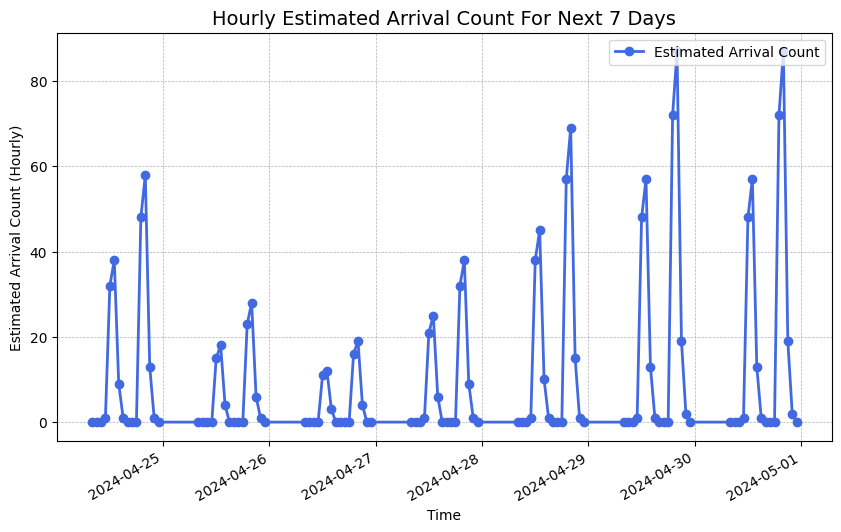

In [52]:
daily_df = generate_daily_prediction()
df = generate_hourly_data(daily_df)
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['estimated_arrival_count'], linestyle='-', color='royalblue', linewidth=2, marker='o', label='Estimated Arrival Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.title('Hourly Estimated Arrival Count For Next 7 Days', fontsize=14)
plt.xlabel('Time')
plt.ylabel('Estimated Arrival Count (Hourly)')
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
plt.show()

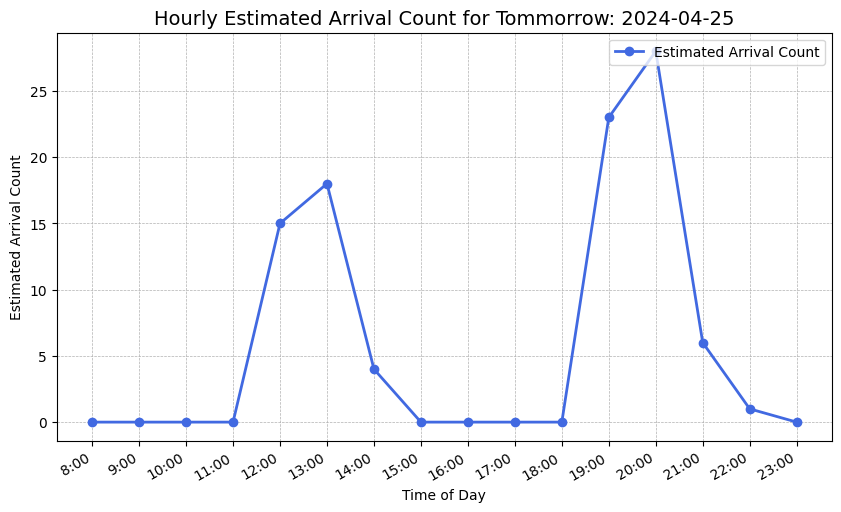

In [53]:
tomorrow = (datetime.now() + timedelta(days=1)).date()
tomorrow_df = df[df['datetime'].dt.date == tomorrow]
plt.figure(figsize=(10, 6))
plt.plot(tomorrow_df['time'], tomorrow_df['estimated_arrival_count'], linestyle='-', color='royalblue', linewidth=2, marker='o', label='Estimated Arrival Count')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.title(f'Hourly Estimated Arrival Count for Tommorrow: {tomorrow}', fontsize=14)
plt.xlabel('Time of Day')
plt.ylabel('Estimated Arrival Count')
plt.gcf().autofmt_xdate()  # Auto-format date labels for better readability
plt.show()